In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
mpl.rcParams['font.size'] = 10

import matplotlib.pyplot as plt

import pyemu
import shutil

import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
# Construct the original model
org_model_ws =  os.path.join('calib', 'model500')


if not os.path.exists(org_model_ws):
    os.makedirs(org_model_ws)

# edit model parmaeters
# bh geometry 
in_csv = pd.read_csv(os.path.join(org_model_ws, 'in.csv'), header=None)

# grid discretisation
grid_dis = 2.5
in_csv.loc[in_csv[0].str.contains('Spatial discretization of grid'), 1] = grid_dis
# ensure peclet >2
Dispersivity = grid_dis/2
in_csv.loc[in_csv[0].str.contains('Dispersivity'), 1] = Dispersivity

in_csv.to_csv(os.path.join(org_model_ws, 'in.csv'), index=False, header=None)

# rebuild flows
top = in_csv.loc[in_csv[0].str.contains('Depth to groundwater level'), 1].values[0]
bot = in_csv.loc[in_csv[0].str.contains('Borehole depth'), 1].values[0]

flows = pd.read_csv(os.path.join(org_model_ws, 'flows - Copy.csv'))
new_flows = pd.DataFrame(columns= flows.columns)
new_flows['Depth [L]'] = np.linspace(top, bot, num=int((bot-top)/grid_dis)+1)
new_flows.iloc[:, 1:] = 1, -1, 0, 0
new_flows.to_csv(os.path.join(org_model_ws, 'flows.csv'), index=False)

import disolv
convertFEC=False

disolv.run(org_model_ws, org_model_ws, calibrate=False, convertFEC=convertFEC,
           method='SLSQP')

No automatic calibration
Equation will be solved at times 0.02, 0.2, 0.5, 1.0, 1.5, 2.0, 3.0, 6.0
8 measured profiles have been found
RMSE: 270.9144943073216


In [3]:
"""new_flows.iloc[:, 1:] = 0, 0, 0, 0

new_flows.loc[new_flows['Depth [L]'] == 48.4, 'In_Flow [L^3 T^-1]'] = 5
new_flows.loc[new_flows['Depth [L]'] == 75, 'In_Flow [L^3 T^-1]'] = 0.5
new_flows.loc[new_flows['Depth [L]'] == 90, 'Out_Flow [L^3 T^-1]'] = -1.4
new_flows.loc[new_flows['Depth [L]'] == 94, 'Out_Flow [L^3 T^-1]'] = -4.1
new_flows.to_csv(os.path.join(org_model_ws, 'flows.csv'), index=False)

disolv.run(org_model_ws, org_model_ws, calibrate=False, convertFEC=convertFEC,
           method='SLSQP')"""

"new_flows.iloc[:, 1:] = 0, 0, 0, 0\n\nnew_flows.loc[new_flows['Depth [L]'] == 48.4, 'In_Flow [L^3 T^-1]'] = 5\nnew_flows.loc[new_flows['Depth [L]'] == 75, 'In_Flow [L^3 T^-1]'] = 0.5\nnew_flows.loc[new_flows['Depth [L]'] == 90, 'Out_Flow [L^3 T^-1]'] = -1.4\nnew_flows.loc[new_flows['Depth [L]'] == 94, 'Out_Flow [L^3 T^-1]'] = -4.1\nnew_flows.to_csv(os.path.join(org_model_ws, 'flows.csv'), index=False)\n\ndisolv.run(org_model_ws, org_model_ws, calibrate=False, convertFEC=convertFEC,\n           method='SLSQP')"

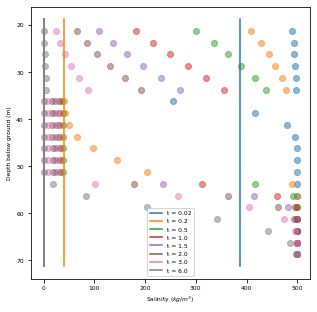

In [4]:
def plot_conc(prof, meas):
    fig = plt.figure(figsize=(5, 5))
    import matplotlib.colors as mcolors
    colours = mcolors.TABLEAU_COLORS

    x = 0
    for col in prof.columns[1:]:
        plt.plot(prof[col], prof['Depth [L]'], label=col, )
            
        plt.scatter(meas.iloc[:,x+1], meas.iloc[:,x+0],  marker = 'o', alpha=0.5)
        x+=2

    plt.ylabel('Depth below ground (m)')
    plt.xlabel('Salinity ($kg/m^3)$')
    plt.legend()

    plt.gca().invert_yaxis()
    return

prof = pd.read_csv(os.path.join(org_model_ws, 'profiles.csv'))
meas = pd.read_csv(os.path.join(org_model_ws, 'measuredprofiles.csv'))

plot_conc(prof, meas)

In [5]:
def ConvertFEC(InData, Temp=20):

    Concentrations = np.zeros(len(InData))
    for i in range(len(InData)):
        if InData[i] < 10000:
            FEC20 = InData[i]/(1 + 0.024 * (Temp - 20))
            Concentrations[i] = (1870 - np.sqrt(1870**2 - 160 * FEC20))/80
        else:
            FEC23 = InData[i]/(1 + 0.024 * (Temp - 23))/1000/1000 * 100
            Concentrations[i] = (5.9738E-7 * FEC23**6 - 3.5136E-5 *
            FEC23**5 + 7.823E-4 * FEC23**4 - 8.0334E-3 * FEC23**3 +
            4.0791E-2 * FEC23**2 + 3.4996E-2 * FEC23 + 3.6104E-2) * 58.44

    return Concentrations

if convertFEC==True:
    meas = pd.read_csv(os.path.join(org_model_ws, 'measuredprofiles - EC.csv'))
    for col in meas.columns[1::2]:
        meas[col] = ConvertFEC(meas[col])

    meas.to_csv(os.path.join(org_model_ws,'measuredprofiles.csv'), index=False)

In [6]:
# prepare calibration datase
# pest template folder
template_ws = os.path.join('calib',"pestpp_template")

In [7]:
# instantiate a PstFrom class
pf = pyemu.utils.PstFrom(original_d=org_model_ws, new_d=template_ws,
                 remove_existing=True, longnames=True)

# add imports
pf.extra_py_imports = ['disolv','pandas', 'os']

# add obs preprocessing function
pf.add_py_function('postprocessor.py', call_str='flows_from_fracs()', is_pre_cmd=True)

# add obs postprocessing function
pf.add_py_function('postprocessor.py', call_str='obs_diff_from_sim()', is_pre_cmd=False)

# add commands to model run
pf.mod_sys_cmds.append("python run_model.py")

# dont calibrate in/out flows directly
# calibrate a total flow and then have fractions; the fraction must add up to 1.0
# scale the fractions by the maximum fration value

# prepapre an input file for total flow; this file will be parameterized by PEST and used by run_model.py to update flows.csv
total_flow = 4
pd.DataFrame([total_flow], columns=['Flow [L^3 T^-1]']).to_csv(os.path.join(template_ws, 'total_flow.csv'))

exp_func = -1
pd.DataFrame([exp_func], columns=['exp_f']).to_csv(os.path.join(template_ws, 'exp_function.csv'))

# prepare a flow fraction csv file; this file will be parameterized by PEST and used by run_model.py to update flows.csv
flows = pd.read_csv(os.path.join(template_ws, 'flows.csv'))

for col in [1,2]:
    numb = flows.iloc[:,col].size
    flows.iloc[:,col] = (1/numb)
    #flows.iloc[:,col] = 1e-9
    #flows.iloc[int(numb/2),col] = 1 - 1e-9

flows.to_csv(os.path.join(template_ws, 'flows_frac.csv'), index=False)

# flow parameters
pf.add_parameters(filenames='flows_frac.csv', mfile_skip=1,
                par_style='direct',
                par_type="grid",
                pargp=['in_flows', 'out_flows'], 
                upper_bound = 1e10, lower_bound=1e-10,
                index_cols=[0], use_cols=[1,2],
                transform='log',
                par_name_base=['in', 'out'])

# total flow parameter
pf.add_parameters(filenames='total_flow.csv', mfile_skip =1, 
                par_style='direct',
                par_type="constant",
                pargp='tot', 
                upper_bound = 1000, lower_bound=1e-3,
                index_cols=[0], use_cols=[1],
                transform='log',
                par_name_base='tot')

# total flow parameter
pf.add_parameters(filenames='exp_function.csv', mfile_skip =1, 
                par_style='direct',
                par_type="constant",
                pargp='exp', 
                upper_bound = 10, lower_bound= -10,
                index_cols=[0], use_cols=[1],
                transform='none',
                par_name_base='exp')


# model parameters
pf.add_parameters(filenames='in.csv', mfile_skip=1,
                par_style='direct',
                par_type="grid",
                pargp='model', 
                upper_bound = 10, lower_bound=-10,
                index_cols=[0], use_cols=[1],
                transform='fixed')


# build the obs file
sim = pd.read_csv(os.path.join(org_model_ws, 'profiles.csv'))
meas = pd.read_csv(os.path.join(org_model_ws, 'measuredprofiles.csv'))

obs = sim.copy()
obs.iloc[:, 1:] = 1e30

for i in range(meas.columns[::2].size):
    depth_col = meas.columns[::2][i]
    val_col = meas.columns[1::2][i]
    df = pd.DataFrame()
    df['x'] = meas[depth_col]
    df['y'] = meas[val_col]

    df.sort_values('x', inplace=True)
    df.drop_duplicates(subset='x', inplace=True)

    x = df['x']
    y = df['y']
    # interpolate measured values
    f = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')

    # interpolate to flow depths
    obs.iloc[:, i+1] = f(obs.iloc[:, 0])

    #plt.plot(x, y, 'o', obs.iloc[:, 0], obs.iloc[:, i+1], '-')
    #plt.show()

obs.fillna(1e30, inplace=True)
obs.to_csv(os.path.join(template_ws, 'profiles.csv'), index=None)

# make difference observations
diff = obs.copy().replace(1e30, np.nan)
diff = diff.diff().replace(np.nan, 1e30)
diff.to_csv(os.path.join(template_ws, 'profiles-diff.csv'), index=None)

# make timedifference observations
tdiff = obs.copy()
tdiff.iloc[:, 1] = 1e30
tdiff.iloc[:, 2]= obs.diff(axis=1).iloc[:, 2:]
tdiff.to_csv(os.path.join(template_ws, 'profiles-tdiff.csv'), index=None)

# get obsg names fromtimes
obsgp = pd.read_csv(os.path.join(template_ws, 'output_times.csv')).iloc[:,0].values
obsgp = ['prof_'+str(i) for i in obsgp]

# add absolute obs
#pf.add_observations(filename='profiles.csv', ofile_sep=None,ofile_skip=1, rebuild_pst=False, zone_array=None, includes_header=False,
#                    index_cols=[0], obsgp=obsgp)
# add differnece obs
pf.add_observations(filename='profiles-diff.csv', ofile_sep=None,ofile_skip=1, rebuild_pst=False, zone_array=None, includes_header=False,
                    index_cols=[0], obsgp=[i+'_d' for i in obsgp], prefix='dif')
# add tdiffernece obs
pf.add_observations(filename='profiles-tdiff.csv', ofile_sep=None, ofile_skip=1, rebuild_pst=False, zone_array=None, includes_header=False,
                    index_cols=[0], obsgp=[i+'_td' for i in obsgp], prefix='tdif')
# add flows as observations/forecasts
pf.add_observations(filename='flows.csv', ofile_skip=1, ofile_sep=None, rebuild_pst=False, zone_array=None, includes_header=False,
                    index_cols=[0],use_cols=[1,2], obsgp=['flow_in', 'flow_out'], prefix='flow_' )


pst = pf.build_pst()

# tidy up parameters
par = pst.parameter_data

# set offset for flows
offset = 1.0
for paragp in ['in_flows', 'out_flows']:
    #set offset
    par.loc[par['pargp']==paragp, ['offset']] = -offset
    #offset bounds
    par.loc[par['pargp']==paragp, ['parlbnd', 'parubnd']] += offset
    # set the initial value at @zero@
    par.loc[par['pargp']==paragp, ['parval1']] += offset 

# set scale for out flows
par.loc[par['pargp'] == 'out_flows', 'scale'] = -1
par.loc[par['pargp'] == 'out_flows', 'parval1'] = abs(par.loc[par['pargp'] == 'out_flows', 'parval1'])

# correct parchglim
par.loc[par['partrans'] != 'none', 'parchglim'] = 'relative'
par.loc[par['pargp'] == 'exp', 'parchglim'] = 'relative'

# add dispersivity and diffusion parameters
#par.loc[par['parnme'].str.contains('Dispersivity') , ['partrans','parlbnd','parubnd', 'pargp']] = 'log', 1e-3, 10, 'disp'
#par.loc[par['parnme'].str.contains('Diffusioncoefficient') , ['partrans','parlbnd','parubnd', 'pargp']] = 'log', 1e-12, 1e-6, 'diff'

# tidy up observations
obs = pst.observation_data
#obs.loc[:, 'weight'] = 1/obs.loc[:, 'obsval']

obs.loc[obs['obsval']== 1e30, 'weight'] = 0
obs.loc[obs['obgnme']=='flow_in', 'weight'] = 0
obs.loc[obs['obgnme']=='flow_out', 'weight'] = 0

# blanace observation groups
# run once
pst.control_data.noptmax = 0
pst.write(os.path.join(pf.new_d, "disolv.pst"))
pyemu.os_utils.run('pestpp-glm disolv.pst', cwd=pf.new_d)
# weight for 100 each
balanced_groups = {grp:100 for grp in pst.nnz_obs_groups}
#balanced_obs = {obs:100 for obs in pst.nnz_obs_names}
#adjust the weights
# reload pst file
pst = pyemu.Pst(os.path.join(pf.new_d, "disolv.pst"))
pst.adjust_weights(obsgrp_dict=balanced_groups)

# add prior information
# set prior info
priorinf = pst.prior_information
for pargp in ['in_flows', 'out_flows']:
    par_list = par.loc[par['pargp']==pargp, 'parnme']
    parval_list = par.loc[par['pargp']==pargp, 'parval1']
    for i in range(len(par_list)):
        parval = parval_list[i]
        par1 = par_list[i]
        par2 = par_list[i-1]
        #pst.add_pi_equation([par1, par2], pilbl=None, rhs=0.0, weight=1.0, obs_group='reg_'+pargp, coef_dict={par1:1, par2:-1})
        #pst.add_pi_equation([par1], pilbl=None, rhs=np.log10(parval), weight=1.0, obs_group='reg_'+pargp, coef_dict={par1:1})
        
# all params must add up to two (out=1 + in=1)
par_list = par.loc[par['pargp'].isin(['in_flows', 'out_flows']), 'parnme']
pst.add_pi_equation(par_list, pilbl=None, rhs=np.log10(2), weight=1.0, obs_group='reg_floweq', coef_dict={par:1 for par in par_list})

# make parameter changes more sensitive
pst.parameter_groups.loc[pst.parameter_groups['pargpnme'].isin(['in_flows', 'out_flows']), ['inctyp', 'derinc']] = 'rel_to_max', 2

# re-write
# tweak settings
#pst.parameter_groups.loc[pst.parameter_groups['pargpnme'].isin(['out_flows', 'in_flows']), 'derinc'] = 0.1

pst.control_data.relparmax = 30
pst.control_data.facparmax = 30
pst.control_data.rlambda1 = 10
pst.control_data.phiredlam = 0.03
pst.control_data.numlam = 10

# add control data section details
pst.pestpp_options["uncertainty"] = False
pst.pestpp_options["lambdas"] = [0.01, 0.1,1,10,100,1000, 10000]
pst.pestpp_options["lambda_scale_fac"] = [0.5, .75, 1.0, 1.1, 1.5]


# set noptmax
pst.control_data.noptmax = 50
# write the updated pest control file
pst.write(os.path.join(pf.new_d, "disolv.pst"))

2021-08-04 17:41:26.689029 starting: opening PstFrom.log for logging
2021-08-04 17:41:26.689029 starting PstFrom process
2021-08-04 17:41:26.689029 starting: setting up dirs
2021-08-04 17:41:26.690058 starting: removing existing new_d 'calib\pestpp_template'
2021-08-04 17:41:26.699001 finished: removing existing new_d 'calib\pestpp_template' took: 0:00:00.008943
2021-08-04 17:41:26.699001 starting: copying original_d 'calib\model500' to new_d 'calib\pestpp_template'
2021-08-04 17:41:26.709972 finished: copying original_d 'calib\model500' to new_d 'calib\pestpp_template' took: 0:00:00.010971
2021-08-04 17:41:26.710970 finished: setting up dirs took: 0:00:00.021941
2021-08-04 17:41:26.715956 starting: adding grid type direct style parameters for file(s) ['flows_frac.csv']
2021-08-04 17:41:26.715956 starting: loading list calib\pestpp_template\flows_frac.csv
2021-08-04 17:41:26.715956 starting: reading list calib\pestpp_template\flows_frac.csv
2021-08-04 17:41:26.717951 finished: reading 

D:\github\pyemu\pyemu\utils\pst_from.py:3007: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_ti.loc[:, "idx_strs"] = df_ti.idx_strs.str.replace("|", ":")


2021-08-04 17:41:26.874377 finished: adding observations from tabular output file '['flows.csv']' took: 0:00:00.013962
noptmax:0, npar_adj:46, nnz_obs:396
2021-08-04 17:41:26.960214 forward_run line:pyemu.os_utils.run(r'python run_model.py')

noptmax:0, npar_adj:46, nnz_obs:322
noptmax:50, npar_adj:46, nnz_obs:322


In [8]:
# run pest glm
#pyemu.helpers.run(f"pestpp-glm disolv.pst",cwd=pf.new_d)

num_workers = 10

m_d = os.path.join('calib', 'master-berambadi')
# worker directory
worker_root = os.path.abspath(os.path.join('r:','Temp','.'))
#worker_root = os.path.join('calib', 'workers')


In [9]:
pyemu.os_utils.start_workers(template_ws,"pestpp-glm", "disolv.pst",num_workers=num_workers,master_dir=m_d, worker_root=worker_root, cleanup=False)

In [10]:
# run the model once to update parameters; parrep does not like these files for some reason
calib_par = pd.read_csv(os.path.join(m_d, 'disolv.par'), delim_whitespace=True, skiprows=1, header=None, names=['parnme', 'parval1', 'scale','offset'] )

par = pst.parameter_data
par.loc[:, 'parval1'] = calib_par['parval1'].values
par.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra,inst,usecol,idx0
parnme,,,,,,,,,,,,,,
in_inst:0_usecol:1_direct_idx0:18.75,in_inst:0_usecol:1_direct_idx0:18.75,log,relative,1.04545,1.0,1.000000e+10,in_flows,1.0,-1.0,1,NaN,0,1,18.75
out_inst:0_usecol:2_direct_idx0:18.75,out_inst:0_usecol:2_direct_idx0:18.75,log,relative,1.04545,1.0,1.000000e+10,out_flows,-1.0,-1.0,1,NaN,0,2,18.75
in_inst:0_usecol:1_direct_idx0:21.25,in_inst:0_usecol:1_direct_idx0:21.25,log,relative,1.04545,1.0,1.000000e+10,in_flows,1.0,-1.0,1,NaN,0,1,21.25
out_inst:0_usecol:2_direct_idx0:21.25,out_inst:0_usecol:2_direct_idx0:21.25,log,relative,1.04545,1.0,1.000000e+10,out_flows,-1.0,-1.0,1,NaN,0,2,21.25
in_inst:0_usecol:1_direct_idx0:23.75,in_inst:0_usecol:1_direct_idx0:23.75,log,relative,1.04545,1.0,1.000000e+10,in_flows,1.0,-1.0,1,NaN,0,1,23.75


In [11]:

# set noptmax
pst.control_data.noptmax = 0
pst.write(os.path.join(m_d, "disolv_calib.pst"))
pyemu.os_utils.run('pestpp-glm disolv_calib.pst', cwd=m_d)

noptmax:0, npar_adj:46, nnz_obs:322


In [12]:
disolv.run(m_d, m_d, calibrate=False, convertFEC=convertFEC,
           method='SLSQP')

No automatic calibration
Equation will be solved at times 0.02, 0.2, 0.5, 1.0, 1.5, 2.0, 3.0, 6.0
8 measured profiles have been found
RMSE: 179.66759474732433


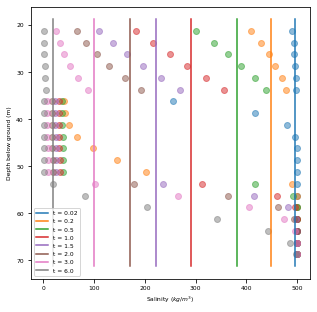

In [13]:
prof = pd.read_csv(os.path.join(m_d, 'profiles.csv'))
meas = pd.read_csv(os.path.join(m_d, 'measuredprofiles.csv'))

plot_conc(prof, meas)

# IES

In [14]:
# add control data section details
pst.pestpp_options["ies_num_reals"] = 200  # enough?
pst.pestpp_options['ies_add_base'] = True
#pst.pestpp_options["parcov"] = "param.unc"
pst.pestpp_options["ies_no_noise"] = True
pst.pestpp_options["ies_autoadaloc"] = True
pst.pestpp_options["ies_subset_size"] = 7
pst.pestpp_options["ies_num_threads"] = 8
#pst.pestpp_options["ies_observation_ensemble"] = 'obs-ensemble.csv'

#pst.pestpp_options["ies_bad_phi"] = 1e30

pst.control_data.noptmax = 50

# write the updated pest control file
pst.write(os.path.join(template_ws, "disolve-ies.pst"))


# run pest
worker_root = os.path.abspath(os.path.join('r:','Temp','.'))
pyemu.os_utils.start_workers(template_ws,"pestpp-ies","disolve-ies.pst",
                                        num_workers=num_workers,
                                        master_dir=m_d, 
                                        worker_root=worker_root, cleanup=False)

noptmax:50, npar_adj:46, nnz_obs:322


Exception: worker root dir not found

In [ ]:
# run the model once to update parameters; parrep does not like these files for some reason
calib_par = pd.read_csv(os.path.join(m_d, 'disolv-ies.base.par'), delim_whitespace=True, skiprows=1, header=None, names=['parnme', 'parval1', 'scale','offset'] )

par = pst.parameter_data
par.loc[:, 'parval1'] = calib_par['parval1'].values

# set noptmax
pst.control_data.noptmax = 0
pst.write(os.path.join(m_d, "disolv_histatch.pst"))
pyemu.os_utils.run('pestpp-glm disolv_histatch.pst', cwd=m_d)

prof = pd.read_csv(os.path.join(m_d, 'profiles.csv'))
meas = pd.read_csv(os.path.join(m_d, 'measuredprofiles.csv'))

fig = plt.figure(figsize=(15, 15))
import matplotlib.colors as mcolors
colours = mcolors.TABLEAU_COLORS

x = 0
for col in prof.columns[1:]:
    plt.plot(prof[col], prof['Depth [L]'], label=col, )
        
    plt.scatter(meas.iloc[:,x+1], meas.iloc[:,x+0],  marker = 'o', alpha=0.5)
    x+=2

plt.ylabel('Depth below ground (m)')
plt.xlabel('Salinity ($kg/m^3)$')
plt.legend()

plt.gca().invert_yaxis()